# Tutorial Inversión de onda completa (FWI: Full Waveform Inversion)

**Importando librerías**

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from skimage.transform import resize
from sympy import Min, Max
from devito import configuration, Function, norm, mmax, Eq, Operator
from examples.seismic import Model, plot_velocity, plot_image, plot_shotrecord, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver

configuration['log-level'] = "ERROR"

**Parametros de adquisición**

In [14]:
nshots = 5  # Numero de disparos por iteración
nreceivers = 70  # Numero de receptores por disparo

origin = (0., 0.)  #origen

# Parámetros para el modelo en (128,128)
shape = (128, 128)  #(nx, nz)
spacing = (5.46875, 5.46875)  #(dx,dz)
# nx * dd = nz * dz = 128 * 5.46875 = 700 m (dominio del modelo)

t0 = 0. # t inicial (ms)
tn = 1000 # t final (ms)
f0 = 0.015 # frecuencia (Hz)

fwi_iterations = 500 # Número de iteraciones para FWI

**Modelo verdadero en 128x128**

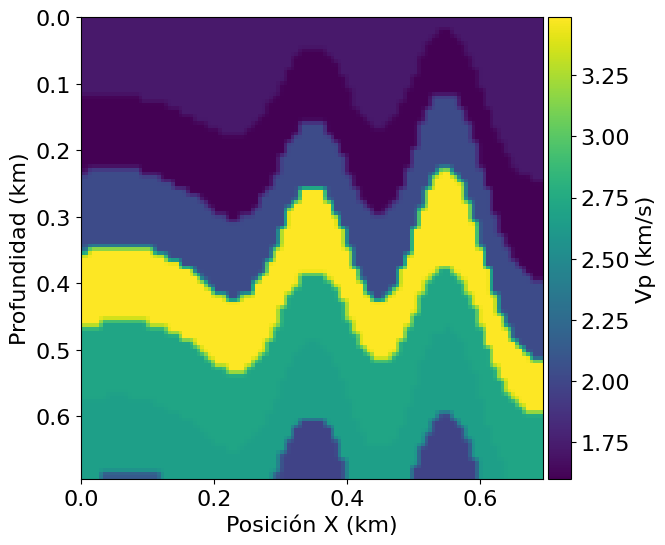

In [15]:
# Cargando el modelo número 69 del pack model56 de OpenFWI en formato (128,128)
m = np.load('modelos/model56[69]_128x128.npy')

# Creando el modelo de velocidad com un objeto de Devito
model = Model(vp=m, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=4, bcs='damp', nbl=120)

# Graficando el modelo
plot_velocity(model) 

**Modelo inicial**

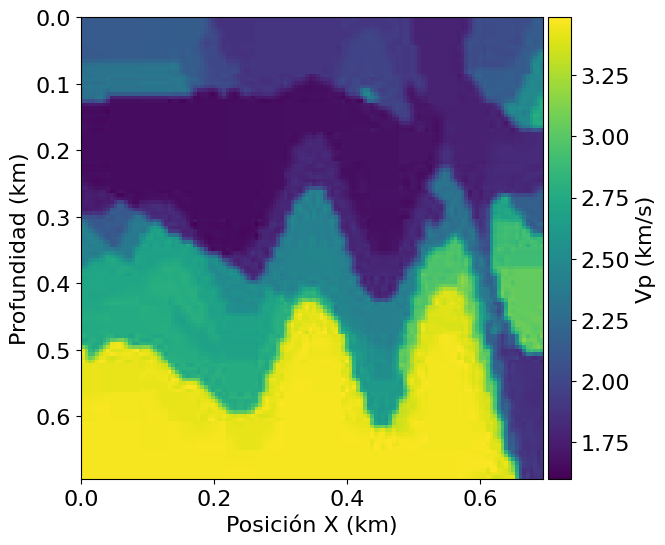

In [36]:
m_i = np.load('modelos/model1.npy') #Modelo en km/s y en formato (128,128)

# Usar el array ajustado como el vp del modelo de velocidad
model0 = Model(vp=m_i, origin=origin, spacing=spacing, dtype=np.float32,
                shape=shape, space_order=2, bcs='damp', nbl=120) 
 

# Graficando el modelo
plot_velocity(model0)

**Graficando la geometría de adquisición**

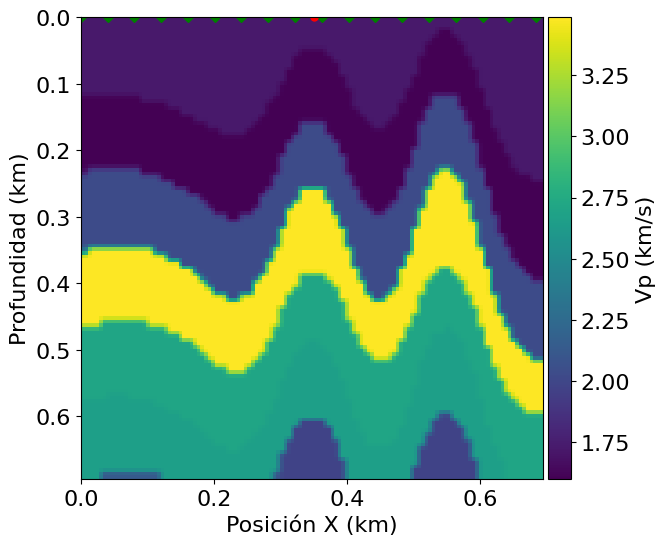

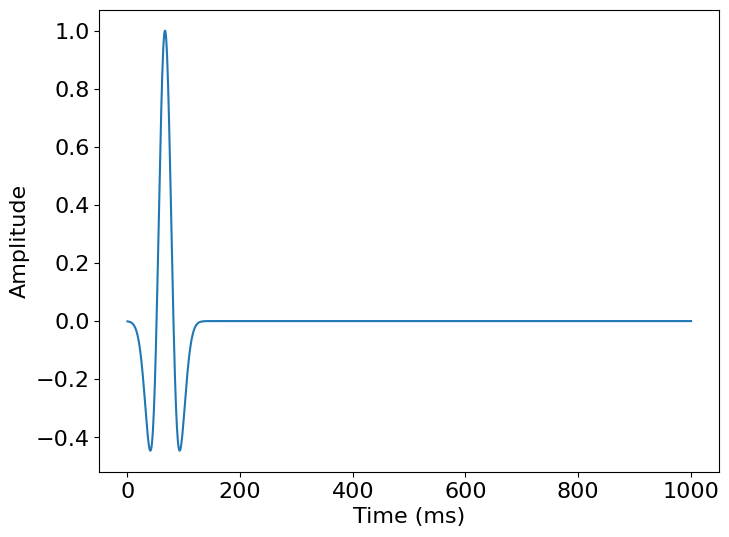

In [37]:
# Posición de las fuentes
src_coordinates = np.empty((1, 2))
src_coordinates[:,0] = 175*2 #X (175*4 = 700)
src_coordinates[:,1] = 0  #Y

# Posiciones de los receptores
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers) #X
rec_coordinates[:, 1] =  0 #Y

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0=t0, tn=tn, f0=f0, src_type='Ricker')

plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

geometry.src.show()

**Forward modelling**

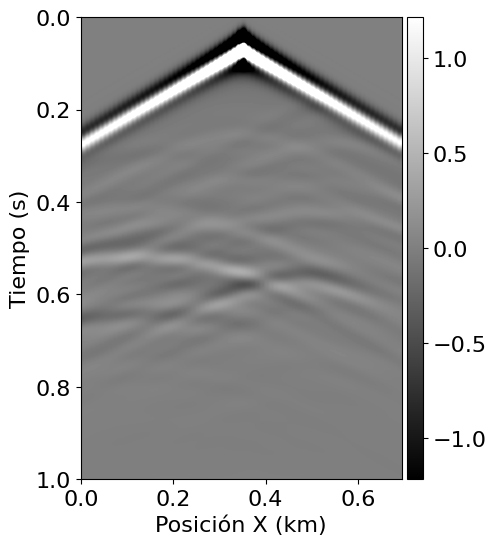

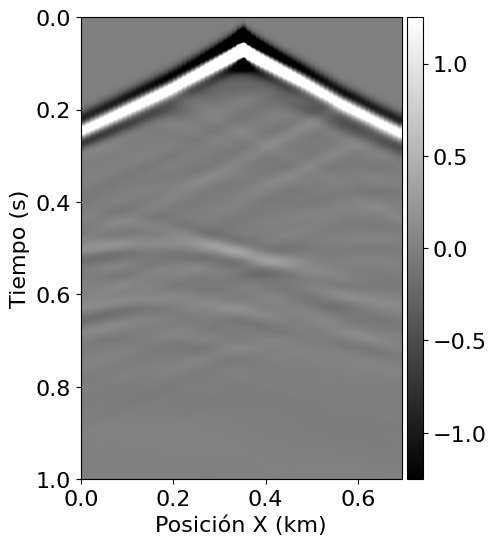

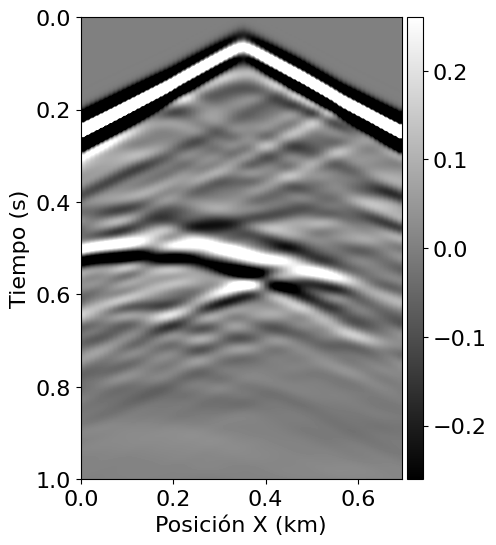

In [38]:
solver = AcousticWaveSolver(model, geometry, space_order=4) # Objeto "solucionador" de la ecuacion de onda

#El dato sísmico es producto del solucionador de la ecuación de onda sobre el modelo de velocidad
true_d, _, _ = solver.forward(vp=model.vp) #Dato verdadero
smooth_d, _, _ = solver.forward(vp=model0.vp) #Dato sintético

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

**Preparación de las fuentes para generar todos los shots iterativamente para el cálculo de gradiente**

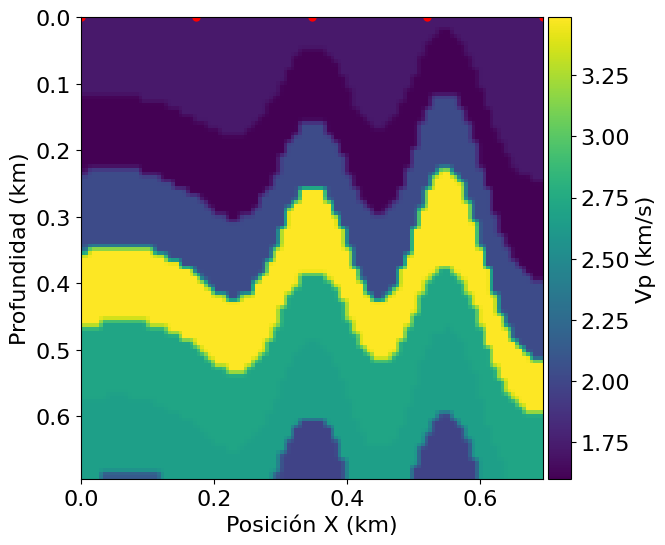

In [39]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0, model.domain_size[0], num=nshots) #X
source_locations[:, 1] = 0 #Y

#Se muestran TODAS las fuentes
plot_velocity(model, source=source_locations)

**Cálculo de residuos y creación de la función del gradiente con objetivo norma l2 (función de costo)**

In [40]:
def compute_residual(residual, dobs, dsyn):
    # if residual.grid.distributor.is_parallel:
    #     # Asegurar que las dimensiones y posiciones entre datos concuerdan para asegurarse de que se está calculando la diferencia en los mismos puntos espaciales
    #     assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
    #     assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)

    #     # Crear operador diferencial, para cada X (por eso el -1)
    #     diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
    #                            dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
    #     # Ejecutar la operación
    #     Operator(diff_eq)()
    # else:
        # Diferencia entre los datos sintéticos y los datos observados
        
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [21]:
def fwi_gradient(vp_in):    
   
    grad = Function(name="grad", grid=model.grid) 

    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Se actualiza la posición de la fuente para cada iteración en el rango nshots
        geometry.src_positions[0,:] = source_locations[i,:]
        
        # Generar datos sintéticos
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Computar gradiente y actualizar la función objetivo (función de costo)
        compute_residual(residual, d_obs, d_syn)
        
        # Norma L2 (función de costo)
        objective += .5*norm(residual)**2 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

# Computar gradiente del modelo inicial
ff, update = fwi_gradient(model0.vp)

**Muestra lo que la actualización le hace al modelo**

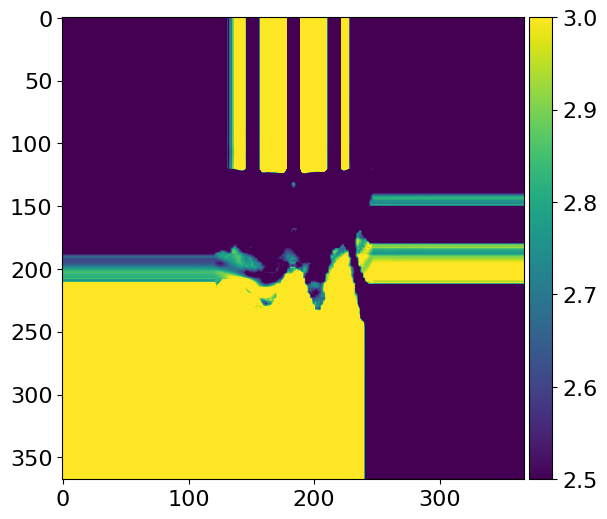

In [22]:
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="viridis")

**Actualización del modelo iterativamente con el método steepest descent**

La función de costo es 18803.097656 en la iteración 1
La función de costo es 18318.970703 en la iteración 2
La función de costo es 17893.078125 en la iteración 3
La función de costo es 17522.759766 en la iteración 4
La función de costo es 17203.115234 en la iteración 5
La función de costo es 16934.453125 en la iteración 6
La función de costo es 16700.414062 en la iteración 7
La función de costo es 16487.193359 en la iteración 8
La función de costo es 16288.603516 en la iteración 9
La función de costo es 16099.316406 en la iteración 10
La función de costo es 15930.531250 en la iteración 11
La función de costo es 15835.995117 en la iteración 12
La función de costo es 15774.145508 en la iteración 13
La función de costo es 15728.871094 en la iteración 14
La función de costo es 15692.558594 en la iteración 15
La función de costo es 15661.486328 en la iteración 16
La función de costo es 15634.099609 en la iteración 17
La función de costo es 15608.545898 en la iteración 18
La función de costo

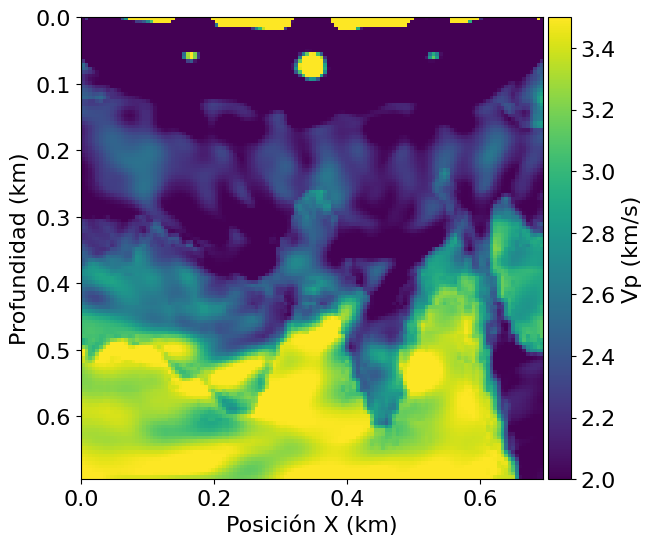

In [23]:
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
   
    # modelo actualizado (update) = modelo anterior (vp) + longitud de paso (alpha) * gradiente (dm)
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

# Arreglo para almacenar la historia de los valores de la función
history = np.zeros((fwi_iterations, 1))

for i in range(0, fwi_iterations):
  
    # phi es la función objetivo y la dirección es el gradiente
    phi, direction = fwi_gradient(model0.vp)
    
    # se guarda el valor de la función de costo en cada iteración
    history[i] = phi
    
    # longitud de paso (learning rate)
    alpha = .05 / mmax(direction)
    
    # actualización del modelo
    update_with_box(model0.vp , alpha , direction)
    
    print('La función de costo es %f en la iteración %d' % (phi, i+1))

# Modelo invertido (modelo inicial al que se le va sumando el gradiente en cada iteración)
plot_velocity(model0)



**Decaimiento de la función de costo**

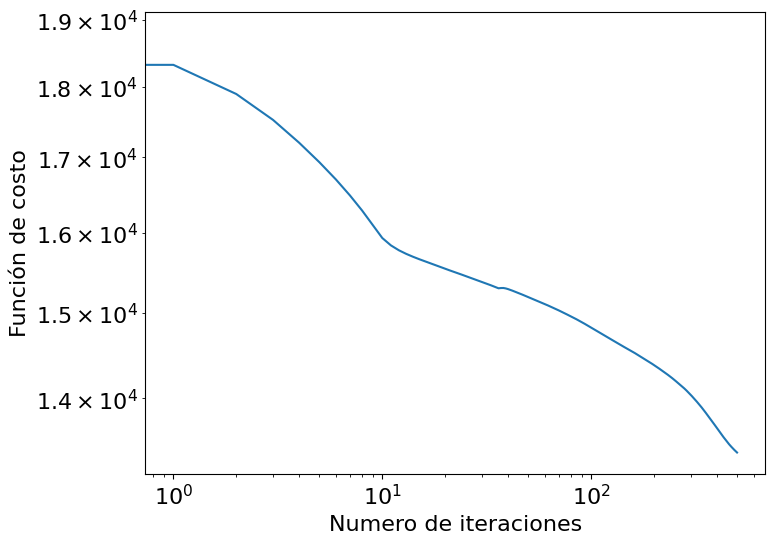

In [25]:
plt.figure()
plt.loglog(history)
plt.xlabel('Numero de iteraciones')
plt.ylabel('Función de costo')
plt.show()